<a href="https://colab.research.google.com/github/abdelmagid07/Pytorch-Pneumonia-Detection/blob/main/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import needed libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import cv2
from PIL import Image
from google.colab import files
import os, shutil

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Upload kaggle key to download needed dataset
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

# Download chest-xray dataset from kaggle and unzip it
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d chest_xray


# Fix nested directories so that chest-xray directly leads to train, val, and test
base = "chest_xray"
for root, dirs, files in os.walk(base):
    if all(x in dirs for x in ["train","val","test"]):
        deepest = root
        if deepest != base:
            for folder in ["train","val","test"]:
                src, dst = os.path.join(deepest, folder), os.path.join(base, folder)
                if os.path.exists(dst): shutil.rmtree(dst)
                shutil.move(src, dst)
            shutil.rmtree(os.path.join(base,"chest_xray"), ignore_errors=True)
        break

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:32<00:00, 283MB/s]
100% 2.29G/2.29G [00:32<00:00, 76.2MB/s]


In [4]:
# Data Augmentation for Training
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# No Augmentation for Validation/Test
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Load Datasets
train_data = datasets.ImageFolder('chest_xray/train', transform=transform_train)
val_data = datasets.ImageFolder('chest_xray/val', transform=transform_test)
test_data = datasets.ImageFolder('chest_xray/test', transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# DIsplay size and structure
print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")


Train: 5216 | Val: 16 | Test: 624


In [6]:
# Build Model - ResNet50 with Transfer Learning
model = models.resnet50(weights='IMAGENET1K_V2')

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Custom classifier head
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

# Training Loop
def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

# Validation Loop
def validate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1, all_labels, all_preds


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]



=== Training Started ===
Epoch 1/15 | Loss: 0.2580 | Train Acc: 0.8886 | Val Acc: 0.8125 | Val F1: 0.8057
Epoch 2/15 | Loss: 0.1710 | Train Acc: 0.9362 | Val Acc: 0.7500 | Val F1: 0.7333
Epoch 3/15 | Loss: 0.1455 | Train Acc: 0.9480 | Val Acc: 0.6875 | Val F1: 0.6537
Epoch 4/15 | Loss: 0.1289 | Train Acc: 0.9486 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 5/15 | Loss: 0.1168 | Train Acc: 0.9588 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 6/15 | Loss: 0.1145 | Train Acc: 0.9546 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 7/15 | Loss: 0.1064 | Train Acc: 0.9595 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 8/15 | Loss: 0.1027 | Train Acc: 0.9607 | Val Acc: 0.9375 | Val F1: 0.9373
Epoch 9/15 | Loss: 0.0895 | Train Acc: 0.9676 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 10/15 | Loss: 0.0995 | Train Acc: 0.9634 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 11/15 | Loss: 0.0898 | Train Acc: 0.9674 | Val Acc: 0.8750 | Val F1: 0.8730
Epoch 12/15 | Loss: 0.0844 | Train Acc: 0.9678 | Val Acc: 0.8750 | Val F1: 0.8730

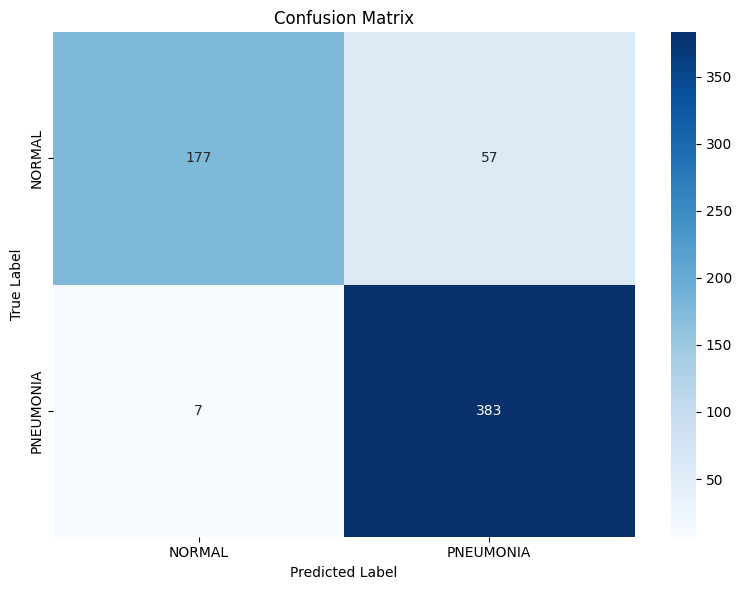

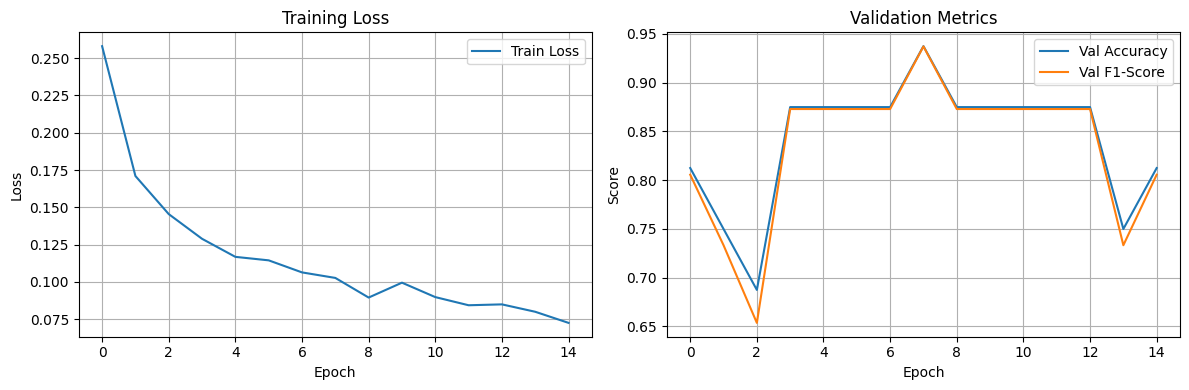

In [ ]:
# Train Model
epochs = 15
train_losses, val_accs, val_f1s = [], [], []

print("\nTraining Started")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_acc, val_f1, _, _ = validate(model, val_loader)

    train_losses.append(train_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

# Final Test Evaluation
test_acc, test_f1, y_true, y_pred = validate(model, test_loader)
print(f"\nTest Results")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1-Score: {test_f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(val_accs, label='Val Accuracy')
ax2.plot(val_f1s, label='Val F1-Score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_title('Validation Metrics')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

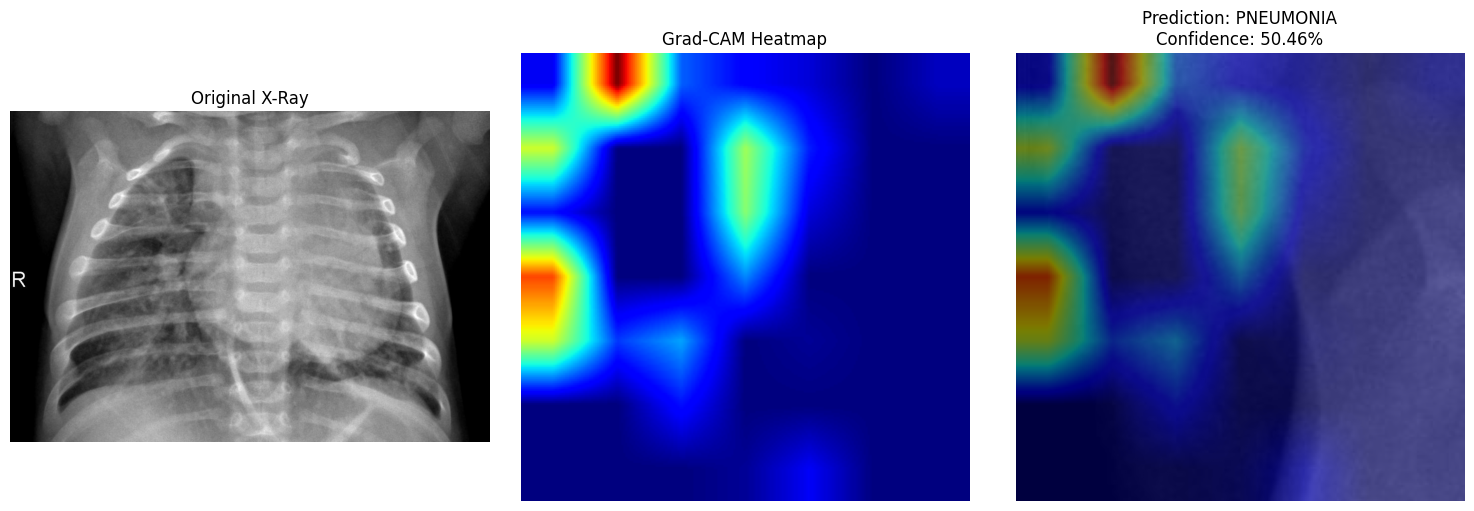

In [8]:
# Grad-CAM Implementation
def grad_cam(model, image_tensor, class_idx):
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.layer4[-1]
    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)

    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)

    model.zero_grad()
    output[0, class_idx].backward()

    grads = gradients[0].cpu().data.numpy()[0]
    acts = activations[0].cpu().data.numpy()[0]

    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam / cam.max() if cam.max() > 0 else cam

    h1.remove()
    h2.remove()

    return cam

# Visualize Grad-CAM on Test Sample
sample_img_path = 'chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
image = Image.open(sample_img_path)
img_tensor = transform_test(image)

output = model(img_tensor.unsqueeze(0).to(device))
pred_class = torch.argmax(output).item()
confidence = torch.softmax(output, dim=1)[0, pred_class].item()

cam = grad_cam(model, img_tensor, pred_class)

# Plot Results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original X-Ray')
axes[0].axis('off')

axes[1].imshow(cam, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

axes[2].imshow(image, cmap='gray')
axes[2].imshow(cam, cmap='jet', alpha=0.5)
axes[2].set_title(f'Prediction: {"PNEUMONIA" if pred_class==1 else "NORMAL"}\nConfidence: {confidence:.2%}')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Save Model
torch.save(model.state_dict(), 'pneumonia_resnet50.pth')
print("\nModel saved as pneumonia_resnet50.pth")
print(f"Final Metrics - Test Acc: {test_acc*100:.2f}% | F1: {test_f1:.4f}")


Model saved as pneumonia_resnet50.pth


NameError: name 'test_acc' is not defined